In [54]:
import numpy as np
import scipy.misc
import glob
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']
num_classes = len(labels) * 2 + 1

# input image dimensions
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

series_imgs = []
series_labels = []
for i, series in enumerate(glob.glob("learn/*.npz")):
    file = np.load(series)
    print(series)
    series_imgs.append(file['imgs'].astype(np.float32))
    series_labels.append(file['labels'])
num_series = len(series_imgs)

learn/21.npz
learn/17.npz
learn/08.npz
learn/09.npz
learn/24.npz
learn/18.npz
learn/06.npz
learn/12.npz
learn/05.npz
learn/16.npz
learn/23.npz
learn/10.npz
learn/01.npz
learn/03.npz
learn/04.npz
learn/14.npz
learn/22.npz
learn/15.npz
learn/20.npz
learn/13.npz
learn/26.npz
learn/27.npz
learn/25.npz
learn/19.npz
learn/07.npz
learn/11.npz
learn/02.npz
learn/00.npz


In [55]:
# load all
x_all = np.empty((0, img_rows, img_cols))
y_all = np.empty((0, 2), np.int32)
for i in range(num_series):
    num_imgs = len(series_imgs[i])
    x_all = np.r_[x_all, series_imgs[i]]
    label_indices = []
    for j, label in enumerate(series_labels[i]):
        label_indices.append(labels.index(label))
    label_and_series = np.c_[label_indices, np.full((num_imgs), i)]
    y_all = np.r_[y_all, label_and_series]

# rot 180
x_all = np.r_[x_all, np.rot90(x_all, 2, (1, 2))]
y_rot = np.copy(y_all)
y_rot[:, 0] += len(labels)
y_all = np.r_[y_all, y_rot]

# space
space_imgs = np.load('learn/space/space.npz')['imgs'].astype(np.float32)
x_all = np.r_[x_all, space_imgs]
y_space = np.full((len(space_imgs), 2), [len(labels) * 2, num_series])
y_all = np.r_[y_all, y_space]

print(x_all.shape)
print(y_all.shape)

# reshape to TF
x_all = x_all.reshape(x_all.shape[0], img_rows, img_cols, 1)
x_all = x_all.astype(np.float32)
x_all /= 255

(790, 64, 64)
(790, 2)


In [56]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.06)

# train_ids = np.where(y_all[:, 1] != 20)
# test_ids = np.where(y_all[:, 1] == 20)
# x_train = x_all[train_ids]
# x_test = x_all[test_ids]
# y_train = y_all[train_ids]
# y_test = y_all[test_ids]
# print(test_ids)
# display_image(np.uint8(x_test[0] * 255)[:, :, 0])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train[:, 0], num_classes)
y_test = keras.utils.to_categorical(y_test[:, 0], num_classes)

In [57]:
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 12, 12, 128)       73856     
__________

In [58]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), steps_per_epoch=x_train.shape[0],
                    epochs=80, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/80
742/742 [==============================] - 11s - loss: 3.2863 - acc: 0.0618 - val_loss: 2.6109 - val_acc: 0.1667
Epoch 2/80
742/742 [==============================] - 11s - loss: 2.5389 - acc: 0.2127 - val_loss: 1.7557 - val_acc: 0.3958
Epoch 3/80
742/742 [==============================] - 11s - loss: 1.9927 - acc: 0.3412 - val_loss: 1.2612 - val_acc: 0.6667
Epoch 4/80
742/742 [==============================] - 11s - loss: 1.5908 - acc: 0.4541 - val_loss: 0.8900 - val_acc: 0.6875
Epoch 5/80
742/742 [==============================] - 11s - loss: 1.3044 - acc: 0.5471 - val_loss: 0.6649 - val_acc: 0.7500
Epoch 6/80
742/742 [==============================] - 11s - loss: 1.0877 - acc: 0.6133 - val_loss: 0.5177 - val_acc: 0.7917
Epoch 7/80
742/742 [==============================] - 11s - loss: 0.8913 - acc: 0.6834 - val_loss: 0.3865 - val_acc: 0.8750
Epoch 8/80
742/742 [==============================] - 11s - loss: 0.7655 - acc: 0.7233 - val_loss: 0.3806 - val_acc: 0.8125
Epoch 9/

742/742 [==============================] - 11s - loss: 0.1041 - acc: 0.9674 - val_loss: 0.1665 - val_acc: 0.9375
Epoch 67/80
742/742 [==============================] - 11s - loss: 0.1020 - acc: 0.9690 - val_loss: 0.1340 - val_acc: 0.9375
Epoch 68/80
742/742 [==============================] - 11s - loss: 0.1068 - acc: 0.9682 - val_loss: 0.1616 - val_acc: 0.9583
Epoch 69/80
742/742 [==============================] - 11s - loss: 0.0904 - acc: 0.9730 - val_loss: 0.1491 - val_acc: 0.9375
Epoch 70/80
742/742 [==============================] - 11s - loss: 0.1066 - acc: 0.9695 - val_loss: 0.1368 - val_acc: 0.9375
Epoch 71/80
742/742 [==============================] - 11s - loss: 0.1082 - acc: 0.9688 - val_loss: 0.1412 - val_acc: 0.9583
Epoch 72/80
742/742 [==============================] - 11s - loss: 0.1114 - acc: 0.9679 - val_loss: 0.0872 - val_acc: 0.9583
Epoch 73/80
742/742 [==============================] - 11s - loss: 0.1022 - acc: 0.9709 - val_loss: 0.1487 - val_acc: 0.9375
Epoch 74/80


In [63]:
model.save_weights('learn/param.hdf5')

In [66]:
model.save_weights('learn/param.hdf5')
pred_res = model.predict(x_test)
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
correct = np.where(res == ans)[0]
errors = np.where(res != ans)[0]
print(errors)

[12  9  8 29 23 10  9 19  1  9  0 28 10 21 20 29 23  2  6  6 29 14 13 22  1
 14 26  2  3 11  0 10  1  1  4  2 26  7  7 11  0  2 14 28 12  3 20 22]
[12  9  8 29 23  9  9 19  1  9  0 28 10 21 20 29 23  2  6  6 29 26 13 22  1
 14 26  2  3 11  0 10  1  1  4  2 26  7  7 11  0  2 14 28 12  3 20 22]
[ 5 21]


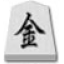

narikei


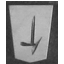

to


In [65]:
for e in errors:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])

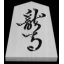

uma


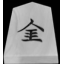

narigin


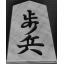

fu


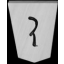

*to


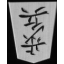

*fu


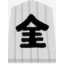

narigin


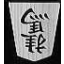

*kei


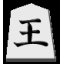

ou


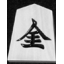

narigin


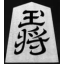

gyoku


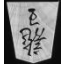

*ryu


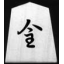

narikei


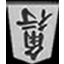

*kaku


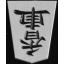

*kyo


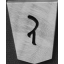

*to


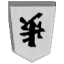

*fu


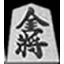

kin


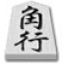

kaku


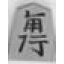

kaku


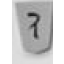

*to


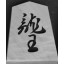

ryu


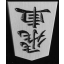

*hi


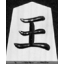

ou


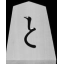

to


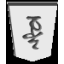

*narikyo


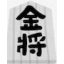

kin


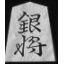

gin


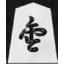

narikyo


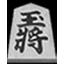

gyoku


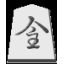

narikei


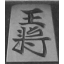

ou


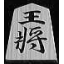

ou


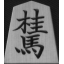

kei


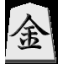

kin


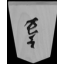

*narikyo


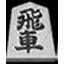

hi


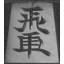

hi


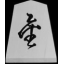

narikyo


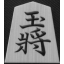

gyoku


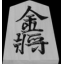

kin


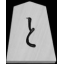

to


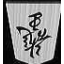

*ryu


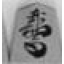

uma


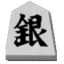

gin


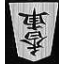

*kyo


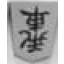

*hi


In [61]:
for e in correct:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    elif len(labels) * 2 > res[e]:
        print("*" + labels[res[e] - len(labels)])
    else:
        print("　")